# DAP Final Project
## 리그오브레전드 - 칼바람 나락 챔피언 분류 및 승패 예측 모델
---
## 목표
'리그오브레전드'의 경기별 승/패 정보와 세부 경기 데이터를 사용해 챔피언을 역할에 따라 클러스터링 하며,  
양 팀 챔피언 조합을 제시해 주었을 때 경기 승패를 예측하는 모델 구현

---
## 개요
데이터는 Riot에서 제공하는 사용자 최근 전적 검색 api를 활용한 크롤링 방법으로 수집했다.  
관련 코드는 별도로 업로드한 https://github.com/YisakH/DAP/tree/main/riotAPI 참조

경기 데이터는 리그오브레전드에서 챔피언(본인의 캐릭터)이 랜덤으로 선택되는 게임모드인 '칼바람 나락' 데이터만을 사용했다.   
챔피언 선택에 플레이어의 의사가 반영되지 않는 만큼, 승패를 예측함에 있어 숙련도나 쓰로잉과 같은 다른 요소들의 영향을 최소화 시킬 수 있을것으로 예상했다.

참고자료:  
riot api 크롤링 - https://yoon1seok.tistory.com/41  
mongodb - https://wooiljeong.github.io/python/mongodb-01/  

---
## Clustering
### 데이터 불러오기
매 경기 플레이어 각각의 데이터에서 numerical feature만을 (챔피언, 킬, 데스, 어시스트, 가한 총 피해량, 받은 총 피해량, 물리/마법 피해량, 가한 군중제어 점수, 승/패 정보 등...) 추출해 clustering에 사용


In [1]:
import pandas as pd
import numpy as np
import math
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
#from google.colab import drive

In [2]:
#drive.mount('/content/drive')
filename = './champInfo_1216.csv'
df = pd.read_csv(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890870 entries, 0 to 4890869
Data columns (total 25 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   _id                             object
 1   assists                         int64 
 2   championName                    object
 3   damageDealtToTurrets            int64 
 4   damageSelfMitigated             int64 
 5   deaths                          int64 
 6   doubleKills                     int64 
 7   goldEarned                      int64 
 8   killingSprees                   int64 
 9   kills                           int64 
 10  largestCriticalStrike           int64 
 11  longestTimeSpentLiving          int64 
 12  magicDamageDealtToChampions     int64 
 13  physicalDamageDealtToChampions  int64 
 14  timeCCingOthers                 int64 
 15  timePlayed                      int64 
 16  totalDamageDealt                int64 
 17  totalDamageDealtToChampions     int64 
 18  to

In [3]:
df.head()

,_id,assists,championName,damageDealtToTurrets,damageSelfMitigated,deaths,doubleKills,goldEarned,killingSprees,kills,...,timePlayed,totalDamageDealt,totalDamageDealtToChampions,totalDamageShieldedOnTeammates,totalDamageTaken,totalHeal,totalHealsOnTeammates,totalTimeCCDealt,trueDamageDealtToChampions,win
0,61baa7a1014c7c33b6c2f94c,24,Viktor,1229,21891,14,2,19628,5,16,...,1662,156103,62618,0,35777,3892,0,419,142,True
1,61baa7a1014c7c33b6c2f94d,36,Lux,2054,11156,9,0,17920,3,8,...,1662,104254,36976,9611,19604,1586,0,258,1382,True
2,61baa7a1014c7c33b6c2f94e,23,Jayce,2438,14533,14,4,22353,5,26,...,1662,131894,46922,0,35727,2984,0,223,514,True
3,61baa7a1014c7c33b6c2f94f,31,Sion,1014,113810,13,0,16251,1,3,...,1662,89137,29669,0,80689,2509,0,305,2397,True
4,61baa7a1014c7c33b6c2f950,22,Graves,2323,21542,14,2,19256,5,15,...,1662,135064,34626,0,39017,3168,0,203,1346,True


---
### 챔피언 이름 기준 grouping
챔피언별 clustering을 목적으로 챔피언 이름을 기준으로 데이터 그룹화  및 정규화

In [4]:
groupDf = df.groupby(df['championName'])
data = pd.DataFrame(groupDf.mean())
data.head(10)

,assists,damageDealtToTurrets,damageSelfMitigated,deaths,doubleKills,goldEarned,killingSprees,kills,largestCriticalStrike,longestTimeSpentLiving,...,timePlayed,totalDamageDealt,totalDamageDealtToChampions,totalDamageShieldedOnTeammates,totalDamageTaken,totalHeal,totalHealsOnTeammates,totalTimeCCDealt,trueDamageDealtToChampions,win
championName,,,,,,,,,,,,,,,,,,,,,
Aatrox,16.668781,781.354448,37031.146610,9.415279,1.169872,12358.643372,1.963918,7.915180,5.747885,199.430148,...,1116.750859,47513.219171,20059.052372,1.443762,39937.632468,15420.524088,7.122687,210.487906,796.800291,0.452154
Ahri,19.179744,1101.073131,8310.983023,8.834022,0.859476,12617.882426,1.949584,7.823789,2.825758,227.135921,...,1146.319368,60116.891268,21163.094410,1.110531,20130.753591,2977.030400,55.734153,74.266126,5160.248336,0.479309
Akali,13.478064,551.339549,19693.909547,9.805742,2.241567,13061.173276,3.084103,11.511796,0.738580,210.109050,...,1156.926313,45974.862263,23437.281448,0.389469,26601.230725,2421.633471,4.751104,34.214637,1700.977111,0.427342
Akshan,15.068905,1566.084457,15271.310487,8.969722,1.693458,13996.800853,2.713643,10.396413,502.475227,225.972842,...,1131.532480,73394.984953,22024.102349,0.058537,21311.328792,1984.001881,105.581017,14.633544,1337.764703,0.464309
Alistar,29.051274,382.823827,54514.616587,9.059993,0.284300,11744.026413,0.748910,4.020022,7.277133,204.290839,...,1134.387957,28087.910491,12582.403399,170.027004,33939.138160,11938.379313,6551.269080,204.517067,960.199889,0.553454
Amumu,21.828743,314.527886,34267.199490,10.641817,0.579804,11712.519899,1.057132,5.351860,6.974235,175.979033,...,1141.179771,33502.579943,15746.052500,39.266966,27040.280500,1463.301439,188.000471,159.557700,1760.679341,0.495965
Anivia,18.739052,986.665992,10057.623653,8.029499,0.791784,12889.510890,1.848529,7.416775,1.095032,267.082996,...,1158.737447,67275.543676,20043.465113,3.474627,22725.142606,1750.000688,59.143943,618.550478,665.817883,0.452809
Annie,19.398435,1030.252170,10073.740396,9.265753,1.241038,12603.457557,2.173549,8.592496,38.352119,211.621453,...,1139.992255,48063.101895,22108.572413,2235.512747,17793.766318,1114.738800,38.512669,102.289768,942.529094,0.512396
Aphelios,16.479722,2692.747769,14104.874152,7.995145,1.652910,13687.219564,2.583899,9.905427,619.133881,247.518672,...,1127.605391,88823.964191,24362.196573,0.123420,23168.183042,3442.795323,118.937237,100.891003,510.600571,0.525384


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
indexes = data.index

data_norm = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

data_norm.head()

,assists,damageDealtToTurrets,damageSelfMitigated,deaths,doubleKills,goldEarned,killingSprees,kills,largestCriticalStrike,longestTimeSpentLiving,...,timePlayed,totalDamageDealt,totalDamageDealtToChampions,totalDamageShieldedOnTeammates,totalDamageTaken,totalHeal,totalHealsOnTeammates,totalTimeCCDealt,trueDamageDealtToChampions,win
championName,,,,,,,,,,,,,,,,,,,,,
Aatrox,0.236297,0.061864,0.516482,0.574496,0.374078,0.325714,0.502973,0.516022,0.004977,0.175221,...,0.200952,0.354246,0.480307,0.000137,0.829833,0.579743,0.000145,0.327514,0.107532,0.202447
Ahri,0.362367,0.104234,0.045050,0.500166,0.266810,0.391731,0.498531,0.507953,0.002416,0.307436,...,0.437726,0.497773,0.520494,0.000104,0.281865,0.075469,0.002691,0.103020,0.841202,0.368755
Akali,0.076099,0.031382,0.231897,0.624427,0.744437,0.504619,0.850082,0.833586,0.000587,0.226182,...,0.522663,0.336728,0.603273,0.000033,0.460874,0.052962,0.000021,0.037016,0.259560,0.050482
Akshan,0.155971,0.165857,0.159301,0.517519,0.555020,0.742884,0.735288,0.735103,0.440299,0.301885,...,0.319318,0.648980,0.551834,0.000000,0.314526,0.035227,0.005302,0.004746,0.198490,0.276886
Alistar,0.857992,0.009051,0.803467,0.529063,0.068040,0.169196,0.126482,0.172100,0.006317,0.198417,...,0.342184,0.133037,0.208160,0.016830,0.663882,0.438629,0.342884,0.317674,0.135006,0.822855


### K-means Clustering

clustering에 적절한 K의 값을 확인하기 위해 K를 1부터 15까지 증가시키며 SSE의 추이 확인 후 6으로 클러스터링 


C:\Users\YisakH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


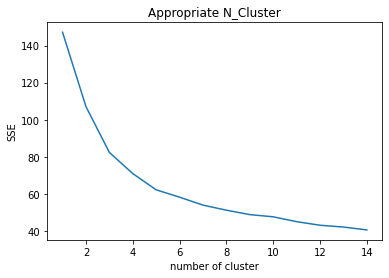

In [6]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 15):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(data_norm.values)
  wcss.append(kmeans.inertia_)

# SSE 추이 그래프
plt.xlabel('number of cluster')
plt.ylabel('SSE')
plt.title('Appropriate N_Cluster')
plt.plot(range(1, 15), wcss)
plt.show()


In [7]:
# 위 그래프를 바탕으로 6으로 clustering
kmeans = KMeans(n_clusters=6, random_state = 20, n_jobs=5)
kmeans.fit(data_norm)

# 클러스터링 결과 데이터셋에 추가
labels = kmeans.predict(data_norm)
clustered_df = data.copy()
clustered_df["cluster"] = labels

clustered_df.head(10)

C:\Users\YisakH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


,assists,damageDealtToTurrets,damageSelfMitigated,deaths,doubleKills,goldEarned,killingSprees,kills,largestCriticalStrike,longestTimeSpentLiving,...,totalDamageDealt,totalDamageDealtToChampions,totalDamageShieldedOnTeammates,totalDamageTaken,totalHeal,totalHealsOnTeammates,totalTimeCCDealt,trueDamageDealtToChampions,win,cluster
championName,,,,,,,,,,,,,,,,,,,,,
Aatrox,16.668781,781.354448,37031.146610,9.415279,1.169872,12358.643372,1.963918,7.915180,5.747885,199.430148,...,47513.219171,20059.052372,1.443762,39937.632468,15420.524088,7.122687,210.487906,796.800291,0.452154,2
Ahri,19.179744,1101.073131,8310.983023,8.834022,0.859476,12617.882426,1.949584,7.823789,2.825758,227.135921,...,60116.891268,21163.094410,1.110531,20130.753591,2977.030400,55.734153,74.266126,5160.248336,0.479309,1
Akali,13.478064,551.339549,19693.909547,9.805742,2.241567,13061.173276,3.084103,11.511796,0.738580,210.109050,...,45974.862263,23437.281448,0.389469,26601.230725,2421.633471,4.751104,34.214637,1700.977111,0.427342,1
Akshan,15.068905,1566.084457,15271.310487,8.969722,1.693458,13996.800853,2.713643,10.396413,502.475227,225.972842,...,73394.984953,22024.102349,0.058537,21311.328792,1984.001881,105.581017,14.633544,1337.764703,0.464309,0
Alistar,29.051274,382.823827,54514.616587,9.059993,0.284300,11744.026413,0.748910,4.020022,7.277133,204.290839,...,28087.910491,12582.403399,170.027004,33939.138160,11938.379313,6551.269080,204.517067,960.199889,0.553454,3
Amumu,21.828743,314.527886,34267.199490,10.641817,0.579804,11712.519899,1.057132,5.351860,6.974235,175.979033,...,33502.579943,15746.052500,39.266966,27040.280500,1463.301439,188.000471,159.557700,1760.679341,0.495965,3
Anivia,18.739052,986.665992,10057.623653,8.029499,0.791784,12889.510890,1.848529,7.416775,1.095032,267.082996,...,67275.543676,20043.465113,3.474627,22725.142606,1750.000688,59.143943,618.550478,665.817883,0.452809,1
Annie,19.398435,1030.252170,10073.740396,9.265753,1.241038,12603.457557,2.173549,8.592496,38.352119,211.621453,...,48063.101895,22108.572413,2235.512747,17793.766318,1114.738800,38.512669,102.289768,942.529094,0.512396,1
Aphelios,16.479722,2692.747769,14104.874152,7.995145,1.652910,13687.219564,2.583899,9.905427,619.133881,247.518672,...,88823.964191,24362.196573,0.123420,23168.183042,3442.795323,118.937237,100.891003,510.600571,0.525384,5


In [8]:
# 클러스터링 결과 확인
for i in range(6):
  tmp = clustered_df[clustered_df['cluster'] == i]
  print(tmp.index)


Index(['Akshan', 'Irelia', 'Kalista', 'Khazix', 'Kindred', 'Lucian',
       'MasterYi', 'Nocturne', 'Pantheon', 'Pyke', 'Qiyana', 'Quinn', 'Rengar',
       'Samira', 'Talon', 'Tristana', 'Tryndamere', 'Twitch', 'Vayne', 'Viego',
       'Yasuo', 'Yone', 'Zed'],
      dtype='object', name='championName')
Index(['Ahri', 'Akali', 'Anivia', 'Annie', 'AurelionSol', 'Azir', 'Bard',
       'Brand', 'Cassiopeia', 'Corki', 'Diana', 'Ekko', 'Elise', 'Evelynn',
       'FiddleSticks', 'Fizz', 'Gragas', 'Heimerdinger', 'Kaisa', 'Karthus',
       'Kassadin', 'Katarina', 'Kayle', 'Kennen', 'KogMaw', 'Leblanc',
       'Lillia', 'Lissandra', 'Lux', 'Malphite', 'Malzahar', 'Mordekaiser',
       'Morgana', 'Nasus', 'Neeko', 'Nidalee', 'Nunu', 'Orianna', 'Rumble',
       'Ryze', 'Shaco', 'Shyvana', 'Swain', 'Sylas', 'Syndra', 'Taliyah',
       'Teemo', 'TwistedFate', 'Veigar', 'Velkoz', 'Vex', 'Viktor', 'Vladimir',
       'Xerath', 'Ziggs', 'Zilean', 'Zoe', 'Zyra'],
      dtype='object', name='championName

In [9]:
# clusering 데이터를 categorical 데이터로 활용하기 위해 매핑
clustered_cate = clustered_df.copy()
mapping = {1:'Mage', 2: 'Fighter', 5:'AD Carry', 4:'Supporter', 3:'Tanker', 0:'Assassin'}
clustered_cate['cluster'] = [mapping[i] for i in clustered_cate['cluster']]

clustered_cate.head()

,assists,damageDealtToTurrets,damageSelfMitigated,deaths,doubleKills,goldEarned,killingSprees,kills,largestCriticalStrike,longestTimeSpentLiving,...,totalDamageDealt,totalDamageDealtToChampions,totalDamageShieldedOnTeammates,totalDamageTaken,totalHeal,totalHealsOnTeammates,totalTimeCCDealt,trueDamageDealtToChampions,win,cluster
championName,,,,,,,,,,,,,,,,,,,,,
Aatrox,16.668781,781.354448,37031.146610,9.415279,1.169872,12358.643372,1.963918,7.915180,5.747885,199.430148,...,47513.219171,20059.052372,1.443762,39937.632468,15420.524088,7.122687,210.487906,796.800291,0.452154,Fighter
Ahri,19.179744,1101.073131,8310.983023,8.834022,0.859476,12617.882426,1.949584,7.823789,2.825758,227.135921,...,60116.891268,21163.094410,1.110531,20130.753591,2977.030400,55.734153,74.266126,5160.248336,0.479309,Mage
Akali,13.478064,551.339549,19693.909547,9.805742,2.241567,13061.173276,3.084103,11.511796,0.738580,210.109050,...,45974.862263,23437.281448,0.389469,26601.230725,2421.633471,4.751104,34.214637,1700.977111,0.427342,Mage
Akshan,15.068905,1566.084457,15271.310487,8.969722,1.693458,13996.800853,2.713643,10.396413,502.475227,225.972842,...,73394.984953,22024.102349,0.058537,21311.328792,1984.001881,105.581017,14.633544,1337.764703,0.464309,Assassin
Alistar,29.051274,382.823827,54514.616587,9.059993,0.284300,11744.026413,0.748910,4.020022,7.277133,204.290839,...,28087.910491,12582.403399,170.027004,33939.138160,11938.379313,6551.269080,204.517067,960.199889,0.553454,Tanker


In [10]:
# 각 챔피언 분류 별 데이터 확인
#cluster_info = clustered_cate.groupby(clustered_df['cluster']).mean()
cluster_info = clustered_cate.groupby(clustered_cate['cluster']).mean()
cluster_info.head()

,assists,damageDealtToTurrets,damageSelfMitigated,deaths,doubleKills,goldEarned,killingSprees,kills,largestCriticalStrike,longestTimeSpentLiving,...,timePlayed,totalDamageDealt,totalDamageDealtToChampions,totalDamageShieldedOnTeammates,totalDamageTaken,totalHeal,totalHealsOnTeammates,totalTimeCCDealt,trueDamageDealtToChampions,win
cluster,,,,,,,,,,,,,,,,,,,,,
AD Carry,19.655426,2057.126518,10774.769142,7.898854,1.503729,13778.247851,2.625032,9.995630,524.699558,255.819294,...,1140.996815,83145.161626,25435.357678,95.170202,21038.771866,3504.100419,374.425192,147.796792,848.942354,0.526471
Assassin,14.874577,1319.161041,18843.411692,9.768471,2.005495,13548.424975,2.949566,11.301364,425.430013,209.515539,...,1131.151721,63627.605880,22716.278597,2.262785,24391.777850,3703.318203,234.046354,80.252102,1658.401977,0.469726
Fighter,17.132372,1028.627641,35383.530830,9.762507,1.260656,12659.611525,2.159405,8.672138,54.291188,197.810890,...,1127.951925,49607.661622,20129.076261,63.925888,33515.858161,7884.571451,77.267646,114.288908,2162.893031,0.478065
Mage,19.244610,1116.536362,13283.901551,8.972669,1.252020,13035.989010,2.302100,8.982535,28.111387,231.383830,...,1153.224910,62484.916589,24126.924800,212.001656,22221.310496,3349.169423,187.389559,176.988238,1022.214523,0.489901
Supporter,29.229668,769.215029,13864.136749,6.894330,0.242775,11488.128301,0.718274,3.458266,5.658294,279.643170,...,1119.286938,27437.643226,10773.413773,5167.169880,18033.410459,9609.346369,5655.242250,178.814159,338.807935,0.520824


### Data visualization

분류된 챔피언 별 데이터를 확인하기 위해 데이터 시각화

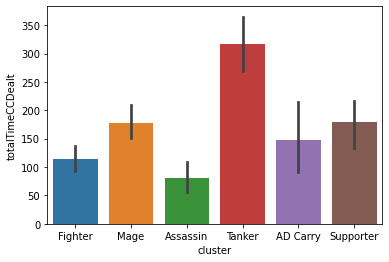

In [11]:
import seaborn as sns
labels = ['Fighter','Mage',  'Tanker', 'Assassin', 'AD Carry', 'Supporter']

p = sns.barplot(x = clustered_cate['cluster'], y=clustered_cate['totalTimeCCDealt'])
#p.set_title("챔피언 분류 별 가한 군중 제어 점수")

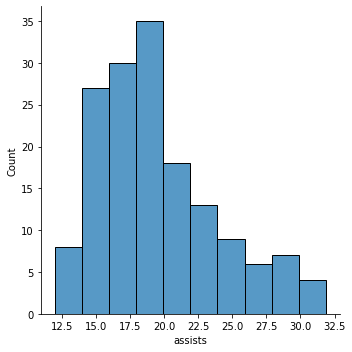

In [12]:
# 어시스트 분포 그래프
sns.displot(clustered_df['assists'])

<AxesSubplot:xlabel='kills', ylabel='totalDamageDealt'>

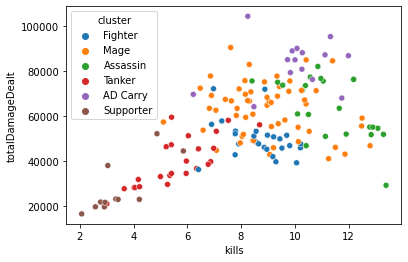

In [14]:
# 챔피언 분류 별 킬 수와 가한 데미지 비교
sns.scatterplot(data=clustered_cate, x='kills', y='totalDamageDealt', hue='cluster')

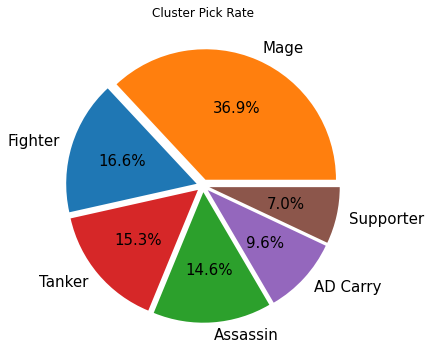

In [15]:
# 챔피언 분류 별 선호도 비교

explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
result = clustered_cate['cluster'].value_counts()
color = ['tab:orange', 'tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:brown']

fig = plt.figure(figsize=(6, 6))
plt.pie(result, labels=result.index, explode = explode, autopct = '%1.1f%%', textprops={'size':15}, colors=color)
plt.title('Cluster Pick Rate')
plt.show()

<AxesSubplot:xlabel='deaths', ylabel='damageSelfMitigated'>

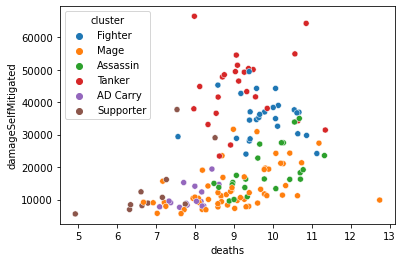

In [16]:
# 받은 피해량과 데스 사이의 인과관계 그래프
sns.scatterplot(data=clustered_cate, x='deaths', y='damageSelfMitigated', hue='cluster')

<AxesSubplot:xlabel='cluster', ylabel='win'>

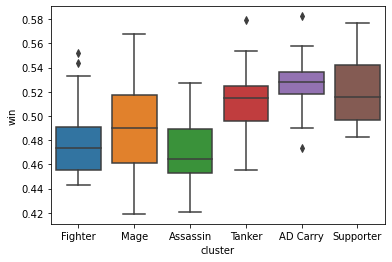

In [17]:
# 챔피언 분류 별 승률 비교
sns.boxplot(x='cluster', y='win', data=clustered_cate)

### Data Classification

크롤링 한 데이터에서 **챔피언 정보, 블루팀의 승패** 여부만을 추출하였으며, Logistic Regression, Decision Tree, Random Forest을 사용해  
1, 2, 3의 모델 실험 및 비교 진행

1. 각 경기 데이터에서 챔피언 이름과 블루팀의 승리 여부만을 사용하며 get-dummy 함수를 통한 One-Hot Incoding 데이터 승/패 예측
2. (1)번과 동일한 raw 데이터를 활용해 get-dummy 대신 차원을 줄일 수 있도록 인코딩을 최적화 하여 승/패 예측
3. (2)번에서 사용한 데이터에 이전 Clustering 결과를 더해 승/패 예측

In [18]:
filename = './selectedDataSortedUser_1216.csv'
match_data = pd.read_csv(filename)

In [19]:
from sklearn.preprocessing import LabelEncoder

match_df = match_data.drop(['matchId', '_id'], axis=1)
match_df

,b0,b1,b2,b3,b4,r0,r1,r2,r3,r4,win
0,Graves,Jayce,Lux,Sion,Viktor,Jhin,Mordekaiser,Nidalee,Teemo,Vladimir,True
1,Ekko,Gnar,Lulu,Neeko,Ziggs,Annie,Elise,Nidalee,Rumble,Urgot,True
2,Lissandra,MasterYi,Seraphine,Tristana,Xerath,Akali,Camille,Urgot,Veigar,Zed,False
3,Aatrox,Hecarim,Jinx,Seraphine,Xerath,Fizz,Graves,Mordekaiser,Samira,Talon,True
4,Akali,Neeko,Taliyah,Tristana,Velkoz,LeeSin,Olaf,Sona,Swain,Veigar,True
...,...,...,...,...,...,...,...,...,...,...,...
489082,Cassiopeia,Pantheon,Singed,Viego,Yuumi,DrMundo,Jayce,Leblanc,Leona,Morgana,False
489083,Azir,Jayce,Lucian,Teemo,Thresh,Gnar,Janna,Kaisa,Veigar,Velkoz,False
489084,Jayce,Kaisa,Kayn,Teemo,Veigar,Diana,Sion,Vi,Viego,Vladimir,True
489085,Alistar,Blitzcrank,Chogath,Elise,Tristana,Karthus,Orianna,Senna,Teemo,Volibear,False


### 1. get dummy incoding

- feature의 수가 1500개에 가깝게 증가
- 해당 데이터에서 Logistic Regression, Decision Tree보다 Random Forest가 더 높은 성능을 보이는 것으로 나타남

In [20]:
# 데이터 확인
dummy_df = pd.get_dummies(match_df)
dummy_df

,win,b0_Aatrox,b0_Ahri,b0_Akali,b0_Akshan,b0_Alistar,b0_Amumu,b0_Anivia,b0_Annie,b0_Aphelios,...,r4_Yasuo,r4_Yone,r4_Yorick,r4_Yuumi,r4_Zac,r4_Zed,r4_Ziggs,r4_Zilean,r4_Zoe,r4_Zyra
0,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,True,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,True,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489082,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489083,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489084,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489085,False,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
feature_set = list(dummy_df.columns)
feature_set.remove('win')

In [22]:
# 인코딩 데이터의 80%는 학습에 20%는 테스트에 사용

features = dummy_df[feature_set]
target = dummy_df.win

from sklearn.model_selection import train_test_split
feature_train, feature_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=1
)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

logreg = LogisticRegression(max_iter=5000)

logreg.fit(feature_train, target_train)

predictions = logreg.predict(feature_test)

print("Accureacy", accuracy_score(target_test, predictions))
print("Classification :")
print(classification_report(target_test, predictions))

Accureacy 0.5996851295262631
Classification :
              precision    recall  f1-score   support

       False       0.59      0.51      0.54     46085
        True       0.61      0.68      0.64     51733

    accuracy                           0.60     97818
   macro avg       0.60      0.59      0.59     97818
weighted avg       0.60      0.60      0.60     97818



In [24]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(n_jobs=5)
clf = clf.fit(feature_train, target_train)

predictions = clf.predict(feature_test)

print("Accureacy", accuracy_score(target_test, predictions))
print("Classification :")
print(classification_report(target_test, predictions))

Accureacy 0.5812733852665154
Classification :
              precision    recall  f1-score   support

       False       0.56      0.55      0.55     46085
        True       0.60      0.61      0.61     51733

    accuracy                           0.58     97818
   macro avg       0.58      0.58      0.58     97818
weighted avg       0.58      0.58      0.58     97818



In [25]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(n_jobs=5)

randomforest.fit(feature_train, target_train)

predictions = randomforest.predict(feature_test)

step1_score = accuracy_score(target_test, predictions)
print("Accureacy", step1_score)
print("Classification :")
print(classification_report(target_test, predictions))

Accureacy 0.6251610133104336
Classification :
              precision    recall  f1-score   support

       False       0.62      0.54      0.58     46085
        True       0.63      0.70      0.66     51733

    accuracy                           0.63     97818
   macro avg       0.62      0.62      0.62     97818
weighted avg       0.62      0.63      0.62     97818



In [26]:
import pickle

In [27]:
save_file1 = './simple_logisitc.sav'
save_file2 = './simple_decision.sav'
save_file3 = './simple_randomforest.sav'
pickle.dump(logreg, open(save_file1, 'wb'))
pickle.dump(clf, open(save_file2, 'wb'))
pickle.dump(randomforest, open(save_file3, 'wb'))

### 2. Custom Incoding

각 팀별 챔피언 유무를 벡터로 나타내 선택된 챔피언만 True로 나타낸다면 블루팀 챔피언 벡터(157개 feature), 레드팀 챔피언 벡터(157개 feature)로 각 경기 챔피언 구성을 One-Hot incoding 할 수 있으며 차원을 1/4로 줄일 수 있음에 착안하여 데이터 재구성.

- 별도의 인코딩 코드는 : https://github.com/YisakH/DAP/tree/main/mongo
- 모든 classifier에서 get dummy 함수로 one hot incoding한 결과보다 높은 성능을 보임

In [28]:
# 인코딩 된 데이터 셋 불러오기
filename = './encodedChamp.csv'
encodedChamp = pd.read_csv(filename)
encoded_match_data = encodedChamp.drop(['_id'], axis=1)
encoded_match_data

,b1,b10,b100,b101,b102,b103,b104,b105,b106,b107,...,r91,r92,r93,r94,r95,r96,r97,r98,r99,win
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489082,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489083,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489084,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
489085,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
feature_set_v2 = list(encoded_match_data.columns)
feature_set_v2.remove('win')

features_v2 = encoded_match_data[feature_set_v2]
target_v2 = encoded_match_data.win

feature_train_v2, feature_test_v2, target_train_v2, target_test_v2 = train_test_split(
    features_v2, target_v2, test_size=0.2, random_state=1
)

In [30]:
logreg_v2 = LogisticRegression(max_iter=5000)

logreg_v2.fit(feature_train_v2, target_train_v2)

predictions = logreg_v2.predict(feature_test_v2)

print("Accureacy", accuracy_score(target_test_v2, predictions))
print("Classification ")
print(classification_report(target_test_v2, predictions))

Accureacy 0.6021079964832649
Classification 
              precision    recall  f1-score   support

       False       0.59      0.51      0.55     46085
        True       0.61      0.68      0.65     51733

    accuracy                           0.60     97818
   macro avg       0.60      0.60      0.60     97818
weighted avg       0.60      0.60      0.60     97818



In [31]:
clf_v2 = DecisionTreeClassifier(n_jobs=5)

clf_v2.fit(feature_train_v2, target_train_v2)
predictions = clf_v2.predict(feature_test_v2)

print("DecisionTree-New Accureacy", accuracy_score(target_test_v2, predictions))
print("Classification ")
print(classification_report(target_test_v2, predictions))

DecisionTree-New Accureacy 0.584278967061277
Classification 
              precision    recall  f1-score   support

       False       0.56      0.57      0.56     46085
        True       0.61      0.60      0.60     51733

    accuracy                           0.58     97818
   macro avg       0.58      0.58      0.58     97818
weighted avg       0.58      0.58      0.58     97818



In [32]:
randomforest_v2 = RandomForestClassifier(n_jobs=5)

randomforest_v2.fit(feature_train_v2, target_train_v2)
predictions = randomforest_v2.predict(feature_test_v2)

step2_score = accuracy_score(target_test, predictions)
print("Accureacy", step2_score)
print("Classification ")
print(classification_report(target_test_v2, predictions))

Accureacy 0.6353125191682513
Classification 
              precision    recall  f1-score   support

       False       0.63      0.56      0.59     46085
        True       0.64      0.70      0.67     51733

    accuracy                           0.64     97818
   macro avg       0.63      0.63      0.63     97818
weighted avg       0.63      0.64      0.63     97818



### 3. Clustering 데이터까지 학습

앞서 2. Custom Incoding 결과를 확인 후 feature의 수와 중요도가 결과의 정확도를 향상시킬 수 있음을 확인했다.  
2.Custom Incoding에서 학습한 데이터는 챔피언 이름만을 학습했을 뿐, 각 챔피언의 게임 내에서의 역할은 알지 못하므로 게임 데이터를 반영한 앞서의 clustering 결과를 학습시킨다면 더 높은 성능을 기대할 수 있을것이라 예상했다.

In [33]:
# 기존 match 데이터에 clustering 데이터 추가

clustering = clustered_df['cluster']

for i in range(0, 5):
  new = clustering.loc[match_df['b' + str(i)]]
  new1 = new.reset_index().drop(['championName'], axis=1)
  match_df['bc' + str(i)] = new1


for i in range(0, 5):
  new = clustering.loc[match_df['r' + str(i)]]
  new1 = new.reset_index().drop(['championName'], axis=1)
  match_df['rc' + str(i)] = new1

match_df

,b0,b1,b2,b3,b4,r0,r1,r2,r3,r4,...,bc0,bc1,bc2,bc3,bc4,rc0,rc1,rc2,rc3,rc4
0,Graves,Jayce,Lux,Sion,Viktor,Jhin,Mordekaiser,Nidalee,Teemo,Vladimir,...,5,5,1,3,1,5,1,1,1,1
1,Ekko,Gnar,Lulu,Neeko,Ziggs,Annie,Elise,Nidalee,Rumble,Urgot,...,1,2,4,1,1,1,1,1,1,2
2,Lissandra,MasterYi,Seraphine,Tristana,Xerath,Akali,Camille,Urgot,Veigar,Zed,...,1,0,4,0,1,1,2,2,1,0
3,Aatrox,Hecarim,Jinx,Seraphine,Xerath,Fizz,Graves,Mordekaiser,Samira,Talon,...,2,2,5,4,1,1,5,1,0,0
4,Akali,Neeko,Taliyah,Tristana,Velkoz,LeeSin,Olaf,Sona,Swain,Veigar,...,1,1,1,0,1,2,2,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489082,Cassiopeia,Pantheon,Singed,Viego,Yuumi,DrMundo,Jayce,Leblanc,Leona,Morgana,...,1,0,3,0,4,3,5,1,3,1
489083,Azir,Jayce,Lucian,Teemo,Thresh,Gnar,Janna,Kaisa,Veigar,Velkoz,...,1,5,0,1,3,2,4,1,1,1
489084,Jayce,Kaisa,Kayn,Teemo,Veigar,Diana,Sion,Vi,Viego,Vladimir,...,5,1,2,1,1,1,3,2,0,1
489085,Alistar,Blitzcrank,Chogath,Elise,Tristana,Karthus,Orianna,Senna,Teemo,Volibear,...,3,3,3,1,0,1,1,5,1,3


위에서 생성된 챔피언 분류 데이터에서 챔피언 분류가 '4'인 것과 '2'인 것은 numerical한 상관 관계가 없으며,  
각 팀이 어떤 분류의 챔피언으로 구성되어 있는지를 학습시켜야 하므로 **팀별로 챔피언 분류를 count하여 하나의 벡터로 표현**

In [34]:
new = match_df.copy()
new = new.drop(['b0', 'b1', 'b2','b3','b4','r0', 'r1','r2','r3','r4', 'win'], axis=1)
a = new[['bc0', 'bc1', 'bc2', 'bc3', 'bc4']]
b = new[['rc0', 'rc1', 'rc2', 'rc3', 'rc4']]

s = a.reset_index().melt('index')
a = pd.crosstab(s['index'],s.value)
a.columns = ['bc0', 'bc1', 'bc2', 'bc3', 'bc4', 'bc5']

s = b.reset_index().melt('index')
b = pd.crosstab(s['index'],s.value)
b.columns = ['rc0', 'rc1', 'rc2', 'rc3', 'rc4', 'rc5']

a.head()
# 아래 데이터 프레임은
# 0번 게임의 블루팀에는 1번분류 챔피언 2개, 2번분류 챔피언 1개, 4번 분류 챔피언 2개로 구성되었다는 의미

,bc0,bc1,bc2,bc3,bc4,bc5
index,,,,,,
0,0,2,0,1,0,2
1,0,3,1,0,1,0
2,2,2,0,0,1,0
3,0,1,2,0,1,1
4,1,4,0,0,0,0


In [35]:
encoded_match_data

,b1,b10,b100,b101,b102,b103,b104,b105,b106,b107,...,r91,r92,r93,r94,r95,r96,r97,r98,r99,win
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489082,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489083,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
489084,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
489085,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [36]:
classification_data = pd.merge(a, b, left_index=True, right_index=True)
final_data = pd.merge(encoded_match_data, classification_data, left_index=True, right_index=True)

final_data

,b1,b10,b100,b101,b102,b103,b104,b105,b106,b107,...,bc2,bc3,bc4,bc5,rc0,rc1,rc2,rc3,rc4,rc5
0,False,False,False,False,False,False,False,False,False,False,...,0,1,0,2,0,4,0,0,0,1
1,False,False,False,False,False,False,False,False,False,False,...,1,0,1,0,0,4,1,0,0,0
2,False,False,False,False,False,False,False,False,False,False,...,0,0,1,0,1,2,2,0,0,0
3,False,False,False,False,False,False,False,False,False,False,...,2,0,1,1,2,2,0,0,0,1
4,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,2,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489082,False,False,False,False,False,False,False,False,False,False,...,0,1,1,0,0,2,0,2,0,1
489083,False,False,False,False,False,False,False,False,False,False,...,0,1,0,1,0,3,1,0,1,0
489084,False,False,False,False,False,False,False,False,False,False,...,1,0,0,1,1,2,1,1,0,0
489085,False,False,False,False,False,False,False,False,False,False,...,0,3,0,0,0,3,0,1,0,1


In [37]:
feature_set_v3 = list(final_data.columns)
feature_set_v3.remove('win')

features_v3 = final_data[feature_set_v3]
target_v3 = final_data.win

feature_train_v3, feature_test_v3, target_train_v3, target_test_v3 = train_test_split(
    features_v3, target_v3, test_size=0.2, random_state=1
)

In [38]:
randomforest_v3 = RandomForestClassifier(n_jobs=5)

randomforest_v3.fit(feature_train_v3, target_train_v3)
predictions = randomforest_v3.predict(feature_test_v3)

step3_score = accuracy_score(target_test, predictions)
print("Accureacy", step3_score)
print("Classification ")
print(classification_report(target_test_v3, predictions))

Accureacy 0.6424686662986362
Classification 
              precision    recall  f1-score   support

       False       0.64      0.57      0.60     46085
        True       0.65      0.71      0.68     51733

    accuracy                           0.64     97818
   macro avg       0.64      0.64      0.64     97818
weighted avg       0.64      0.64      0.64     97818



---
## 결론

- Random Forest 모델을 통해 약 64.5%의 정확도를 보이는 승/패 예측 모델을 구현할 수 있음
- 하지만 경기의 승패는 챔피언 구성 뿐 아니라 사용자의 실력, 숙련도, 아이템 선택 등의 다양한 요소의 영향을 받으며 챔피언 정보 데이터만을 사용해 70% 이상 정확도를 보이는 모델을 만드는 데 한계가 있음을 확인